In [2]:
!pip3 install tensorflow==2.0.0.beta

     |████████████████████████████████| 87.9MB 115kB/s 
     |████████████████████████████████| 3.1MB 38.7MB/s 
     |████████████████████████████████| 501kB 54.4MB/s 
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [4]:
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

print ("TernsorFlow Version: ", tf.__version__)
print ("numpy version: ", np.__version__)
print ("matplotlib version: ", matplotlib.__version__) 

TernsorFlow Version:  2.0.0-beta0
numpy version:  1.17.4
matplotlib version:  3.1.2


#### Synthetic Data Preparation 

In [0]:
def plot_series(time, series, format="--", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 900
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 900

In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    # series = tf.expand_dims(series, axis=-1)
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda y: y.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda y: (y[:-1], y[1:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

##### Helper Code Block to Understand the Function 

In [0]:
a = tf.data.Dataset.range(12)
a = a.window(3, shift=2, drop_remainder=True)
a = a.flat_map(lambda x: x.batch(3))

print ("windowed and batch size if 3: \n")
for ele in a:
  print (ele.numpy())



##### Shuffle and separate features and labels 

a_ds = a.shuffle(2).map(lambda x: (x[:-1], x[-1]))

print ("shuffled and separated in features and labels: \n")

for ele_ds in a_ds:
  print (ele_ds)


a_ds = a_ds.batch(3).prefetch(2)

print ("Creating 3 batches of features and labels: \n")
for f in a_ds:
  print(f)


windowed and batch size if 3: 

[0 1 2]
[2 3 4]
[4 5 6]
[6 7 8]
[ 8  9 10]
shuffled and separated in features and labels: 

(<tf.Tensor: id=24612, shape=(2,), dtype=int64, numpy=array([0, 1])>, <tf.Tensor: id=24613, shape=(), dtype=int64, numpy=2>)
(<tf.Tensor: id=24616, shape=(2,), dtype=int64, numpy=array([2, 3])>, <tf.Tensor: id=24617, shape=(), dtype=int64, numpy=4>)
(<tf.Tensor: id=24620, shape=(2,), dtype=int64, numpy=array([6, 7])>, <tf.Tensor: id=24621, shape=(), dtype=int64, numpy=8>)
(<tf.Tensor: id=24624, shape=(2,), dtype=int64, numpy=array([4, 5])>, <tf.Tensor: id=24625, shape=(), dtype=int64, numpy=6>)
(<tf.Tensor: id=24628, shape=(2,), dtype=int64, numpy=array([8, 9])>, <tf.Tensor: id=24629, shape=(), dtype=int64, numpy=10>)
Creating 3 batches of features and labels: 

(<tf.Tensor: id=24643, shape=(3, 2), dtype=int64, numpy=
array([[0, 1],
       [2, 3],
       [6, 7]])>, <tf.Tensor: id=24644, shape=(3,), dtype=int64, numpy=array([2, 4, 8])>)
(<tf.Tensor: id=24647, shape

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [0]:
#### Create the Data-Set

train_dataset = windowed_dataset(x_train, window_size, batch_size=64, shuffle_buffer=shuffle_buffer_size)

#### Building up the Model

In [5]:
model = tf.keras.models.Sequential([tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]), 
                                    tf.keras.layers.Conv1D(filters=16, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None, 1]),
                                    tf.keras.layers.Conv1D(filters=32, kernel_size=3, strides=1, padding='causal', activation='relu'),   
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)), 
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,)), 
                                    tf.keras.layers.Dense(1),
                                    # tf.keras.layers.Dense(10),  
                                    tf.keras.layers.Lambda(lambda x: x*200)])



model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          96        
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          1568      
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          16640     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
_________________________________________________________________
lambda_1 (Lambda)            (None, 1)                 0

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')  

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


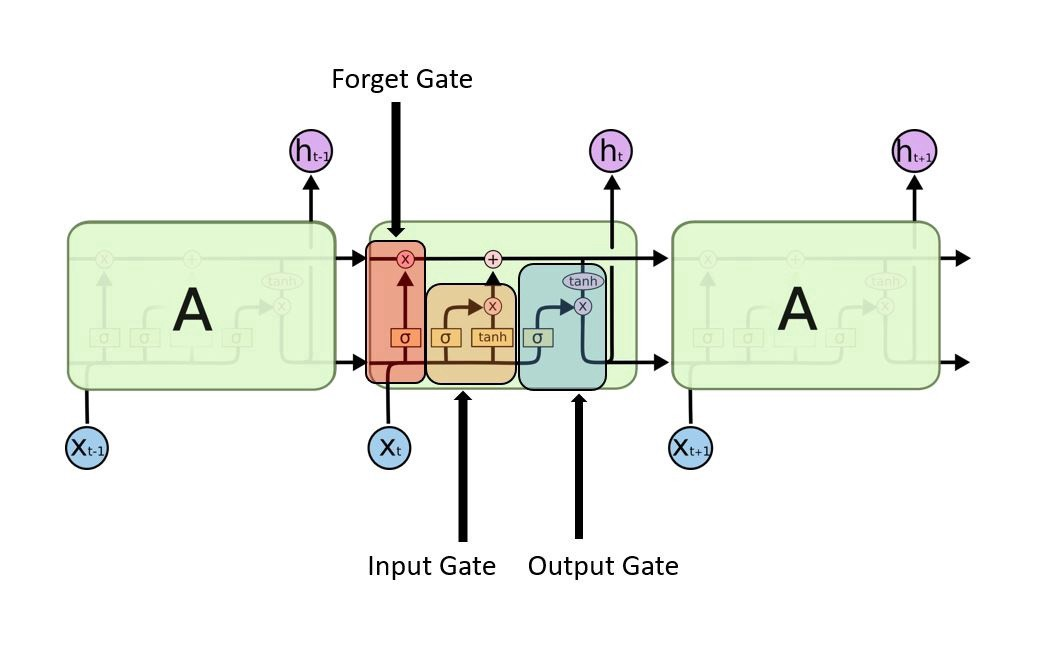

In [0]:
from google.colab import files
from IPython.display import Image
Image('/content/gdrive/My Drive/Colab Notebooks/Time_Series/Time_SeriesW4/LSTM_schematic.jpeg', width=600)

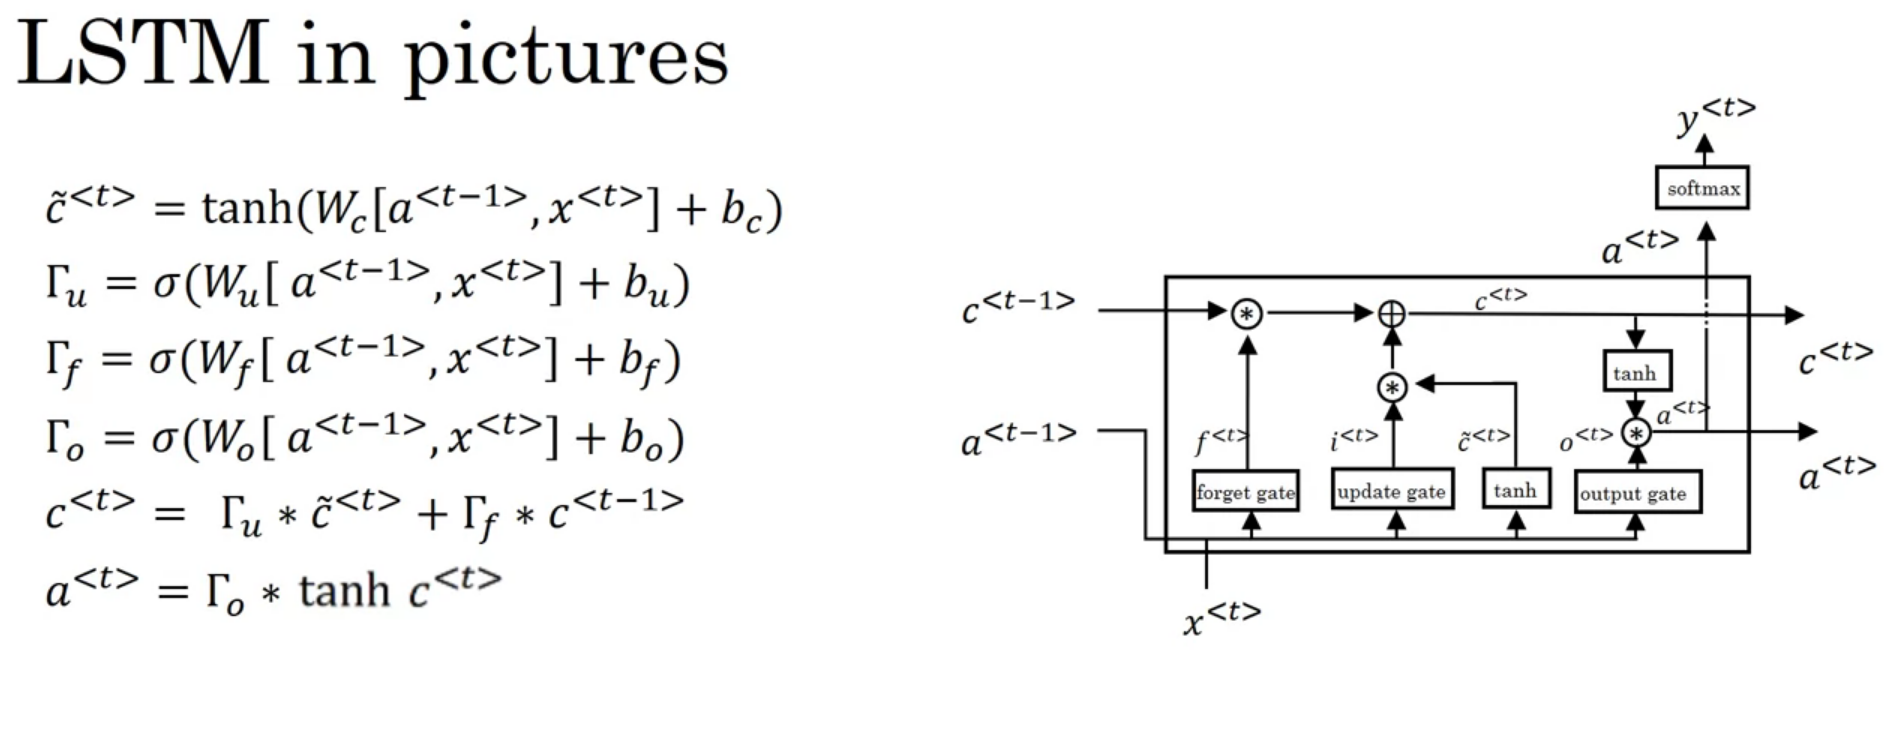

In [0]:
Image('/content/gdrive/My Drive/Colab Notebooks/Time_Series/Time_SeriesW4/LSTM_schematic1_formulas.png', width=800)

#### Understanding the Number of Parameters 

Number of filters $=n_f$ <br>
Kernel size $=n_c$ <br>
Input dimension $=id$ 


1. Start of with the Lambda layer. Just change the shape of the tensor
2. Next layer is Conv1d layer. So number of parameters:  $1 \times n_f \times  n_c + n_f = (16\times 5) + 16 = 96$. 
3. Let's add another conv layer for understanding. $n_f = 32, n_c = 3$. Output shape from the previous layer now becomes the dimension of the input, which is 16. So, number of parameters: $(16\times 32\times 3) + 32 = 1568$.    _This layer was not used in  the initial model building. Only one conv layer with $n_f=32, n_c = 5$ was used_.

4. Now comes the LSTM layers. First take a look at the schematic images of LSTM from Chris Olah's post and Andrew Ng's lecture notes. LSTM consists of 3 gates forget, update (input gate in Olah's schematic) and output gate. The update or input gate are divided in two parts. The first 2 equations from Andrew Ng's slide represent that. The other equations are forget and output gate.   

5. All the parameters of LSTM layer comes from these 4 gates. So let's try to count for one gate and then multiply by 4. 

6. $\textrm{Unit}$ in LSTM layer represents the dimension of the cell state. For more check the [stack page](https://stackoverflow.com/questions/44273249/in-keras-what-exactly-am-i-configuring-when-i-create-a-stateful-lstm-layer-wi). Now to calculate the number of parameters rather than describing here in detail, I recommend two sources... a) [stack exchange page](https://datascience.stackexchange.com/questions/10615/number-of-parameters-in-an-lstm-model) and b) Arun Mallya's [blog](http://arunmallya.github.io/writeups/nn/lstm/index.html#/). 

7. Finally for number of parameters we will use the formulation--<br> 
parameters $=  ((\textrm{Unit} \times id) + (\textrm{Unit}\times \textrm{Unit}) + \textrm{Unit}) \times 4$ <br>
parameters = $( (32 \times 32) + 32^2 + 32 ) \times 4 = 8320$. Since we are using bi-directional LSTM so, total parameters $8320 \times 2 = 16640$. 

8. Similarly for the second LSTM layer... <br>
parameters $= ( (64\times 32) + 32^2 + 32 ) \times 4 = 12416$. For Bi-LSTM 24832.  

In [0]:
!ls "/content/gdrive/My Drive/Colab Notebooks/Time_Series/Time_SeriesW4"  

LSTM_Conv1D_Week4.ipynb       LSTM_schematic.jpeg
LSTM_schematic1_formulas.png  time_series_LSTM.png


In [0]:
learning_rate = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * (10** (epoch / 20)))

optimizer = tf.keras.optimizers.RMSprop(lr=1e-8, rho=0.90)

model.compile(loss=tf.keras.losses.Huber(), 
              optimizer=optimizer, 
              metrics=["mae"])

history = model.fit(train_dataset, epochs=150, callbacks=[learning_rate])

Epoch 1/150
14/14 [==============================] - 6s 430ms/step - loss: 52.0860 - mae: 52.6225
Epoch 2/150
14/14 [==============================] - 1s 61ms/step - loss: 52.0735 - mae: 52.6075
Epoch 3/150
14/14 [==============================] - 1s 59ms/step - loss: 52.0589 - mae: 52.5930
Epoch 4/150
14/14 [==============================] - 1s 61ms/step - loss: 52.0435 - mae: 52.5775
Epoch 5/150
14/14 [==============================] - 1s 61ms/step - loss: 52.0272 - mae: 52.5612
Epoch 6/150
14/14 [==============================] - 1s 62ms/step - loss: 52.0097 - mae: 52.5437
Epoch 7/150
14/14 [==============================] - 1s 62ms/step - loss: 51.9902 - mae: 52.5243
Epoch 8/150
14/14 [==============================] - 1s 61ms/step - loss: 51.9675 - mae: 52.5016
Epoch 9/150
14/14 [==============================] - 1s 61ms/step - loss: 51.9411 - mae: 52.4753
Epoch 10/150
14/14 [==============================] - 1s 61ms/step - loss: 51.9113 - mae: 52.4455
Epoch 11/150
14/14 [========

In [0]:
#### Choose Learning Rate 

print ("minimum value of loss: ", min(history.history['loss']))
min_indcs = [i for i, x in enumerate(history.history['loss']) if x==min(history.history['loss'])]
final_lr = history.history['lr'][min_indcs[0]]
print ("corresponding index: ", min_indcs)
print ("corresponding learning rate: ", history.history['lr'][min_indcs[0]])

minimum value of loss:  5.9584944985129615
corresponding index:  [76]
corresponding learning rate:  6.309574e-05


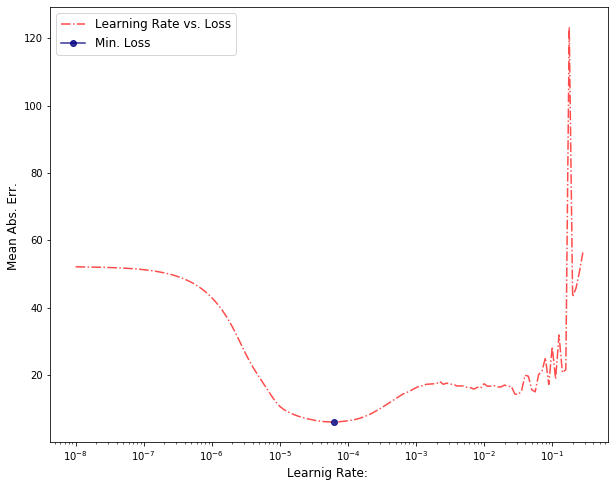

In [0]:
fig = plt.figure(figsize=(10, 8))
lr1 = history.history['lr']
loss1 = history.history['loss'] 
plt.ylabel('Mean Abs. Err. ', fontsize=12)
plt.xlabel('Learnig Rate: ', fontsize=12)
plt.semilogx(lr1, loss1, linestyle='-.', color='red', alpha=0.7, label='Learning Rate vs. Loss')
plt.plot(final_lr, min(history.history['loss']), marker='o', color='navy', alpha=0.8, label='Min. Loss')
plt.legend(fontsize=12)
plt.show()

In [0]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

In [0]:
train_dataset1 = windowed_dataset(x_train, window_size, batch_size=64, shuffle_buffer=shuffle_buffer_size)

model1 = tf.keras.models.Sequential([tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]), 
                                    tf.keras.layers.Conv1D(filters=32, kernel_size=5, strides=1, padding='causal', activation='relu', input_shape=[None, 1]), 
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)), 
                                    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32,)), 
                                    tf.keras.layers.Dense(1), 
                                    tf.keras.layers.Lambda(lambda x: x*200)])



model1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, None, 1)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 32)          192       
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 64)          16640     
_________________________________________________________________
bidirectional_3 (Bidirection (None, 64)                24832     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
_________________________________________________________________
lambda_3 (Lambda)            (None, 1)                 0         
Total params: 41,729
Trainable params: 41,729
Non-trainable params: 0
__________________________________________________

In [0]:
optimizer1 = tf.keras.optimizers.RMSprop(lr=final_lr, rho=0.90)

model1.compile(loss=tf.keras.losses.Huber(), 
              optimizer=optimizer1, 
              metrics=["mae"])

history1 = model1.fit(train_dataset1, epochs=520)

Epoch 1/520
14/14 [==============================] - 6s 435ms/step - loss: 22.1094 - mae: 22.7620
Epoch 2/520
14/14 [==============================] - 1s 63ms/step - loss: 10.5384 - mae: 11.0612
Epoch 3/520
14/14 [==============================] - 1s 60ms/step - loss: 8.7290 - mae: 9.2276
Epoch 4/520
14/14 [==============================] - 1s 60ms/step - loss: 7.8443 - mae: 8.3326
Epoch 5/520
14/14 [==============================] - 1s 61ms/step - loss: 7.2826 - mae: 7.7706
Epoch 6/520
14/14 [==============================] - 1s 60ms/step - loss: 6.8416 - mae: 7.3326
Epoch 7/520
14/14 [==============================] - 1s 61ms/step - loss: 6.6587 - mae: 7.1404
Epoch 8/520
14/14 [==============================] - 1s 63ms/step - loss: 6.3513 - mae: 6.8301
Epoch 9/520
14/14 [==============================] - 1s 63ms/step - loss: 6.1655 - mae: 6.6448
Epoch 10/520
14/14 [==============================] - 1s 62ms/step - loss: 6.0505 - mae: 6.5299
Epoch 11/520
14/14 [========================

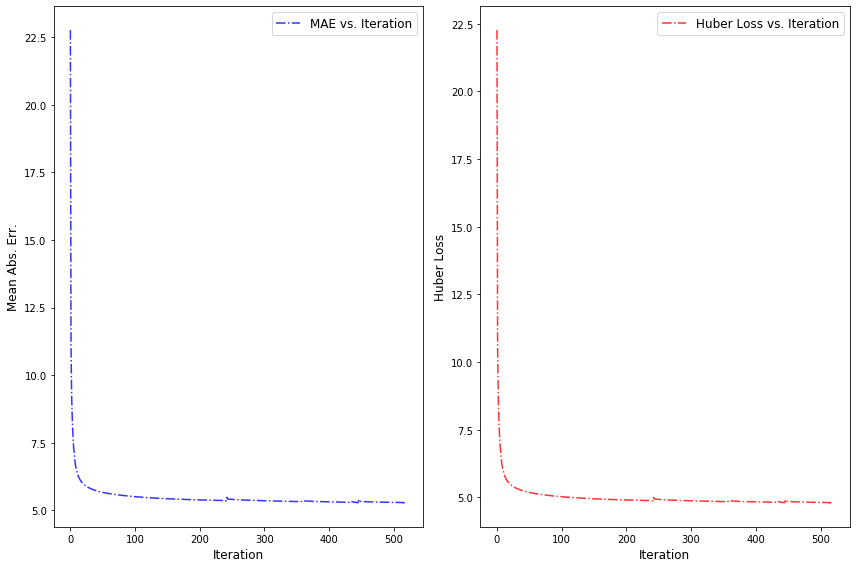

In [0]:
fig = plt.figure(figsize=(12, 8))
mae_final = history1.history['mae']
loss_final = history1.history['loss']
iteration = range(len(mae_final))

plt.subplot(1, 2, 1)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Mean Abs. Err.', fontsize=12)
plt.plot(iteration, mae_final, linestyle='-.', color='blue', alpha=0.8, label='MAE vs. Iteration')
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Huber Loss', fontsize=12)
plt.plot(iteration, loss_final, linestyle='-.', color='red', alpha=0.8, label='Huber Loss vs. Iteration')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

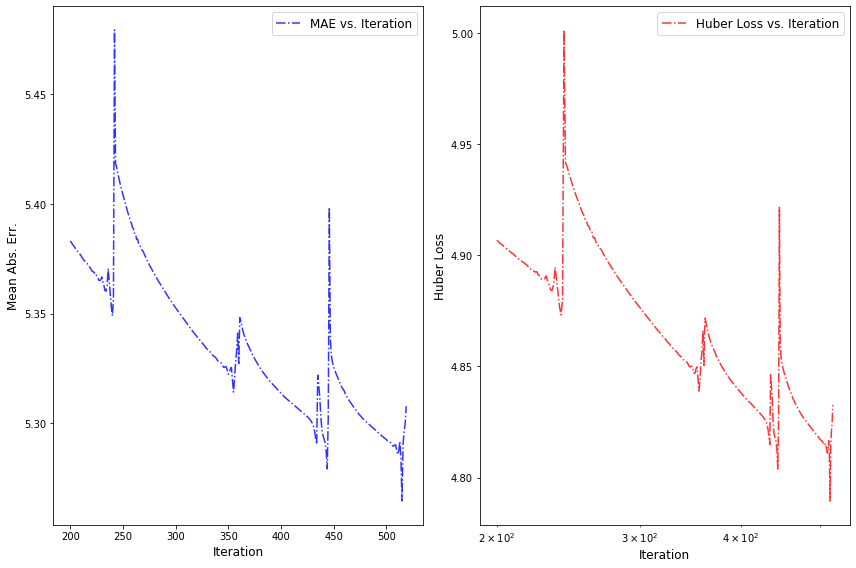

In [0]:
#### Zoomed in the last few iterations

iteration_zoom = iteration[200:]
mae_final_zoom = mae_final[200:]
loss_final_zoom = loss_final[200:]

fig = plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Mean Abs. Err.', fontsize=12)
plt.plot(iteration_zoom, mae_final_zoom, linestyle='-.', color='blue', alpha=0.8, label='MAE vs. Iteration')
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Huber Loss', fontsize=12)
plt.xscale('log')
plt.plot(iteration_zoom, loss_final_zoom, linestyle='-.', color='red', alpha=0.8, label='Huber Loss vs. Iteration')
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


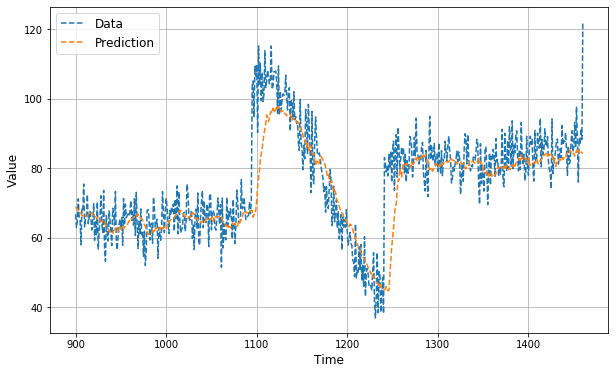

In [0]:
forecast = []
results = []
for time in range(len(series) - window_size):
  forecast.append(model1.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, results)
labels = ['Data', 'Prediction']
plt.legend(labels, fontsize=12)
plt.savefig('./time_Series_LSTM.png', dpi=300)
plt.show()

In [0]:
print ("final MAE: ", tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

final MAE:  5.8964868
